In [2]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

CompileError: pyross/inference.pyx

In [3]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [4]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])/1e4).astype('int')
Ni[1] = (np.sum(Ni0[4:8])/1e4).astype('int')
Ni[2] = (np.sum(Ni0[8:12])/1e4).astype('int')
Ni[3] = (np.sum(Ni0[12:16])/1e4).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N 

135333.0


In [5]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )

In [6]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

In [7]:
times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [8]:
beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([10]*M)
A0   = np.array([10]*M)
Ia0  = np.array([10]*M)# each age group has asymptomatic infectives
Is0  = np.array([10]*M)# and also symptomatic infectives
Ih0  = np.array([10]*M)
Ic0  = np.array([10]*M)
Im0  = np.array([10]*M)
R0   = np.zeros(M)

S0   = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni)
contactMatrix=C

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)

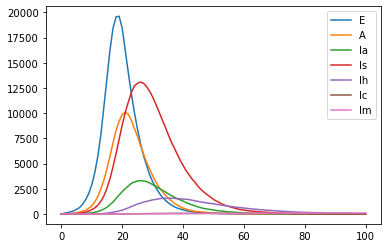

In [9]:
# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')

plt.legend()
plt.show()

In [10]:
Tf = 19 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf,:8*M]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
#parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

#plt.plot(x[:, M])
#plt.show()

-5617.139210247893
28.946200847625732


In [12]:
aW_g = 0.5 
aW_bounds = [0.1, 0.8]
aS_g = 0.5
aS_bounds = [0.1, 0.8]
aO_g = 0.5
aO_bounds = [0.1, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = data['X']/N
x = x[22:,:8*M]
Nf = x.shape[0] 
Tf = Nf-1 

times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

-24763.82948049735


In [13]:
eps = 1e-3 
start_time = time.time() 

#parameters = estimator.make_params_dict(params)
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
estimator.set_params(parameters) 
params, nit = estimator.infer_control(guess, x, Tf, Nf, generator, bounds,
                                  niter=2, eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

parameters: [0.55076476 0.55076476 0.55076476]
parameters: [0.53580216 0.54991267 0.5580288 ]
parameters: [0.41151621 0.55192582 0.63935228]
parameters: [0.40823557 0.54793546 0.65040502]
parameters: [0.40747496 0.54536419 0.65348737]
basinhopping step 0: f -24768.6
parameters: [0.45575598 0.53679302 0.59197193]
parameters: [0.46189962 0.55192895 0.61294584]
parameters: [0.45637457 0.55239304 0.61740572]
parameters: [0.40834891 0.54708537 0.651617  ]
parameters: [0.40756177 0.5402122  0.65423455]
parameters: [0.4088229  0.51601262 0.66097442]
parameters: [0.40882863 0.5160127  0.66096628]
basinhopping step 1: f -24768.6 trial_f -24768.6 accepted 1  lowest_f -24768.6
found new global minimum on step 1 with function value -24768.6
parameters: [0.40277459 0.54986554 0.65836181]
parameters: [0.40133139 0.5477379  0.65706415]
basinhopping step 2: f -24768.5 trial_f -24768.5 accepted 1  lowest_f -24768.6
[0.40882863 0.5160127  0.66096628]
2
6086.72140622139
